In [1085]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from bs4 import BeautifulSoup
import requests
import numpy as np


In [1086]:
#reading the three data files
companies = pd.read_csv('companies.csv',encoding='ISO-8859-1')
rounds = pd.read_csv('rounds2.csv',encoding='ISO-8859-1')

In [1087]:
mapping = pd.read_csv('mapping.csv',encoding='ISO-8859-1')

In [1088]:
#extracting name from permalink and converting it to lower case for comparison
rounds['company_permalink'] = rounds.apply(lambda x: x['company_permalink'].split('/')[-1].lower(),axis=1)
companies['permalink'] = companies.apply(lambda x:  x['permalink'].split('/')[-1].lower(),axis=1)

In [1089]:
#getting number of unique compaines
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66099,61191,27296,4,137,311,1092,5111,3978
top,notesfirst,#NAME?,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [1090]:
#getting number of unique companies
rounds.describe(exclude=[np.number])

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at
count,114949,114949,114949,31140,114949
unique,66370,114949,14,8,5033
top,solarflare,/funding-round/0c72292e3356ef0dc4c3315ec9b15440,venture,A,01-01-2014
freq,19,1,55494,14747,779


In [1091]:
#creating the master data frame
master_frame = rounds.merge(companies,left_on='company_permalink',right_on='permalink',how='left')

In [1092]:
master_frame.describe(exclude=[np.number])

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,114949,114949,114949,31140,114949,114942,114941,108810,111535,114942,106271,104003,104782,104785,94422
unique,66370,114949,14,8,5033,66363,66094,61188,27295,4,137,311,1092,5111,3977
top,solarflare,/funding-round/0c72292e3356ef0dc4c3315ec9b15440,venture,A,01-01-2014,solarflare,Solarflare Communications,http://www.solarflare.com,Biotechnology,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,19,1,55494,14747,779,19,19,19,8165,90151,72308,26664,19078,7422,4642


In [1093]:
#dropping out columns that are not used in further analysis or cause redundancy
master_frame.drop(['permalink','funding_round_code','homepage_url','funded_at','name','state_code',\
                   'region','city','founded_at'],axis=1,inplace=True)

In [1094]:
#getting the number of null values
(master_frame.isnull().sum()/len(master_frame))*100

company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
raised_amount_usd          17.390321
category_list               2.970013
status                      0.006090
country_code                7.549435
dtype: float64

In [1095]:
#removing rows with null value in raised_amount_usd column as this is our primary column and 
#rows with null country_code,category_list as null_country codes/category will get rejected further down the line,
#thus making the data less bulky for further analysis
master_frame = master_frame[~(master_frame['raised_amount_usd'].isnull()) & ~(master_frame['country_code'].isnull())
                           & ~(master_frame['category_list'].isnull())]


In [1096]:
set(master_frame['status'])

{'acquired', 'closed', 'ipo', 'operating'}

In [1097]:
(master_frame.isnull().sum()/len(master_frame))*100

company_permalink          0.0
funding_round_permalink    0.0
funding_round_type         0.0
raised_amount_usd          0.0
category_list              0.0
status                     0.0
country_code               0.0
dtype: float64

In [1098]:
master_frame.groupby('funding_round_type').mean()

,raised_amount_usd
funding_round_type,
angel,9.715739e+05
convertible_note,1.337187e+06
debt_financing,1.716765e+07
equity_crowdfunding,5.098980e+05
grant,4.512698e+06
non_equity_assistance,4.807534e+05
post_ipo_debt,1.694518e+08
post_ipo_equity,6.607706e+07
private_equity,7.393849e+07


PLOTTING GRAPH NUMBER 1 HERE

In [1099]:
funding_type = ['venture','angel','seed','private_equity']

mean_amount = master_frame[master_frame['funding_round_type'].isin(funding_type)].\
              groupby('funding_round_type').mean()/10**6

number_of_investments = master_frame[master_frame['funding_round_type'].isin(funding_type)].\
                        groupby('funding_round_type')['company_permalink'].count()

fraction_of_investments = (number_of_investments[:]/sum(number_of_investments))*100


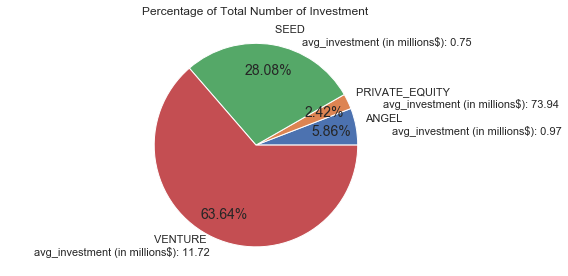

In [1100]:
labels = list(map(lambda x,y:'\n'+x.upper()+' \n         avg_investment (in millions$): '+\
                  str(y[0].round(2))+'\n',list(mean_amount.index),list(mean_amount.values)))

fig1,ax1 = plt.subplots()
plt.title('Percentage of Total Number of Investment\n')
ax1.pie(list(fraction_of_investments),labels=labels,autopct='%.2f%%',pctdistance=0.75,\
        labeldistance=1.088,radius=10.0)

ax1.axis('equal')
plt.tight_layout()
plt.show()
fig1.savefig('investment_pct.png',dpi=fig1.dpi,bbox_inches='tight')


END OF PLOT

In [1101]:
master_frame = master_frame[master_frame['funding_round_type']=='venture']

In [1102]:
# getting the list of countries where english is the official language from wikipedia
url = requests.get('https://en.wikipedia.org/wiki/List_of_territorial_entities_where_\
                   English_is_an_official_language').text
soup = BeautifulSoup(url,'lxml')
tables = soup.find_all('table',class_='wikitable sortable')
english_speaking_countries = []
for tb_no in range(2):
    table = tables[tb_no]
    data_rows = table.find_all('td')
    countries = [data_rows[tb_no].text.strip() for tb_no in range(2,len(data_rows),6)]
    english_speaking_countries.extend(countries)

In [1103]:
top9 = master_frame[master_frame['country_code'].isin(english_speaking_countries)].\
       groupby('country_code').sum().sort_values(by='raised_amount_usd',ascending=False).head(9)

In [1104]:
top9

,raised_amount_usd
country_code,
USA,4.200680e+11
GBR,2.007281e+10
IND,1.426151e+10
CAN,9.482218e+09
SGP,2.793918e+09
IRL,1.669286e+09
AUS,1.319029e+09
NZL,4.483164e+08
ZAF,2.337131e+08


PLOTTING GRAPH NUMBER 2 HERE

<BarContainer object of 9 artists>

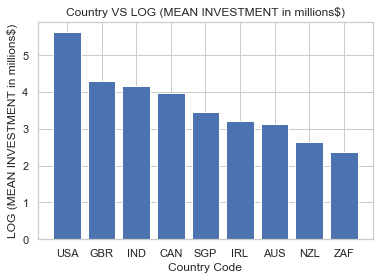

In [1105]:
labels = list(top9.index)
values = list(np.log10(top9['raised_amount_usd']/10**6))
fig1,ax1 = plt.subplots()
plt.title('Country VS LOG (MEAN INVESTMENT in millions$)')
plt.xlabel('Country Code')
plt.ylabel(u'LOG (MEAN INVESTMENT in millions$)')
ax1.bar(labels,values)
# fig1.savefig('investment_countrywise.png',bbox_inches='tight')
# plt.close()

END OF PLOT

In [1106]:
mapping.describe()

,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,0.031977,0.001453,0.077035,0.129360,0.091570,0.058140,0.104651,0.283430,0.222384
std,0.176066,0.038125,0.266841,0.335843,0.288627,0.234177,0.306326,0.450991,0.416150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1107]:
mapping.head(5)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [1108]:
#extracting primary sector from category_list
master_frame['primary_sector'] = master_frame.apply(lambda x: str(x['category_list']).split('|')[0],axis=1)

In [1109]:
#upon analyis found that many spelling mismatches between primary_sector and category_list columns where '0'
# is present inplace of 'na'
category_in_mapping = set(mapping['category_list'])
category_master = set(master_frame['primary_sector'])
cat_map = category_in_mapping.difference(category_master)
def replace(category):
    s = category.split('0')
    if len(s)>=2 and s[0]!='':
        return 'na'.join(s)
    else:
        return 'Na'+s[1]
  

In [1110]:
mapping['category_list'] = mapping.apply(lambda x: replace(x['category_list']) if ((x['category_list'] in cat_map) and ('0' in str(x['category_list']))) else x['category_list'],axis=1)

In [1111]:
#checking whether any mismatch is left
print("Categories present in Maste_frame but not in mapping\n",category_master.difference(set(mapping['category_list'])))
for word in set(mapping['category_list']):
    if '0' in str(word):
        print(word)

Categories present in Maste_frame but not in mapping
 {'Product Search', 'GreenTech', 'Retirement', 'Enterprise Hardware', 'Adaptive Equipment', 'Specialty Retail', 'Biotechnology and Semiconductor', 'Rapidly Expanding', 'English-Speaking', 'Racing', 'Natural Gas Uses'}
Enterprise 2.0


In [1112]:
#removing any leading/trailing spaces from category_list entries
mapping['category_list'] = mapping.apply(lambda x: str(x['category_list']).strip(),axis=1)
#dropping the blank category as it is not used further
mapping.drop('Blanks',axis=1,inplace=True)
#making the category_list column the index of mapping dataframe
mapping.set_index('category_list',inplace=True)
#extracting the main sectors in a list
main_sectors = list(mapping.columns)


In [1113]:
#Some values are present in master_dataframe but not in mapping. By default putting them into Others,but for some 
#the main_sector can be guessed
mapping.loc['Greentech'] = [0,1,0,0,0,0,0,0] #main sector- Cleantech / Semiconductors
mapping.loc['Specialty Retail'] = [0,0,0,0,0,0,0,1]#main sector - Social, Finance, Analytics, Advertising
mapping.loc['Racing'] = [1,0,0,0,0,0,0,0] #main sector - Automotive & SPorts
mapping.loc['Enterprise Hardware'] = [0,0,0,0,1,0,0,0] #main sector - Manufacturing

In [1114]:
main_sectors = pd.Series(main_sectors)
print(main_sectors)

0                        Automotive & Sports
1                 Cleantech / Semiconductors
2                              Entertainment
3                                     Health
4                              Manufacturing
5                 News, Search and Messaging
6                                     Others
7    Social, Finance, Analytics, Advertising
dtype: object


In [1115]:
#mapping function for primary sector to main_sector
def get_sector(primary_sector):
    if primary_sector in list(mapping.index):
        return mapping.loc[primary_sector,:]
    else:
        return [0,0,0,0,0,0,1,0]
 

In [1116]:
       
master_frame['main_sector'] = master_frame.apply(lambda x:'Blank' if x['primary_sector']=='nan'\
                                                 else main_sectors[list(map(bool,get_sector(\
                                                 x['primary_sector'])))].values[0],axis=1)

In [1117]:
master_frame.describe(exclude=[np.number])

,company_permalink,funding_round_permalink,funding_round_type,category_list,status,country_code,primary_sector,main_sector
count,47809,47809,47809,47809,47809,47809,47809,47809
unique,27332,47809,1,9946,4,97,603,8
top,endogastric-solutions,/funding-round/0c72292e3356ef0dc4c3315ec9b15440,venture,Biotechnology,operating,USA,Biotechnology,Others
freq,14,1,47809,5402,34996,35943,6794,11426


In [1118]:
#selecting main sectors other than blank and only those records with investment between 5 to 15 million
master_frame = master_frame[~(master_frame['main_sector']=='Blank') & (5*10**6<=master_frame['raised_amount_usd']) 
                           & (15*10**6>=master_frame['raised_amount_usd'])]

In [1119]:
#breaking up the master frame into 3 separate frames for the top 3 countries
D1 = master_frame[master_frame['country_code']=='USA']
D2 = master_frame[master_frame['country_code']=='GBR']
D3 = master_frame[master_frame['country_code']=='IND']

In [1120]:
import warnings
warnings.filterwarnings('ignore')
#finding the number and total amount of investment in each sector
D1['investment_count_sectorwise'] = D1.groupby(['main_sector'])['company_permalink'].transform('count')
D1['total_investment_sectorwise'] = D1.groupby(['main_sector'])['raised_amount_usd'].transform('sum')

D2['investment_count_sectorwise'] = D2.groupby(['main_sector'])['company_permalink'].transform('count')
D2['total_investment_sectorwise'] = D2.groupby(['main_sector'])['raised_amount_usd'].transform('sum')

D3['investment_count_sectorwise'] = D3.groupby(['main_sector'])['company_permalink'].transform('count')
D3['total_investment_sectorwise'] = D3.groupby(['main_sector'])['raised_amount_usd'].transform('sum')


In [1121]:
print('Total number of investments in C1:',sum(set(D1['investment_count_sectorwise'])))
print('Total number of investments in C2:',sum(set(D2['investment_count_sectorwise'])))
print('Total number of investments in C3:',sum(set(D3['investment_count_sectorwise'])))

print('Total amount of investments in C1:',sum(set(D1['total_investment_sectorwise'])))
print('Total amount of investments in C2:',sum(set(D2['total_investment_sectorwise'])))
print('Total amount of investments in C3:',sum(set(D3['total_investment_sectorwise'])))


Total number of investments in C1: 12064
Total number of investments in C2: 621
Total number of investments in C3: 328
Total amount of investments in C1: 107766584223.0
Total amount of investments in C2: 5379078691.0
Total amount of investments in C3: 2949543602.0


In [1122]:
print("Percent of closed/acquired companies in C1:",round(100*len(D1[(D1['status']=='closed') \
                                                   | (D1['status']=='acquired')])/len(D1),2))

Percent of closed/acquired companies in C1: 30.1


In [1123]:
print("Percent of closed/acquired companies in C2:",round(100*len(D2[(D2['status']=='closed') \
                                                   | (D2['status']=='acquired')])/len(D2),2))

Percent of closed/acquired companies in C2: 22.71


In [1124]:
print("Percent of closed/acquired companies in C3:",round(100*len(D3[(D3['status']=='closed') \
                                                   | (D3['status']=='acquired')])/len(D3),2))

Percent of closed/acquired companies in C3: 9.15


In [1125]:
def get_top_sector_countrywise(data):
    df = data[['country_code','main_sector','investment_count_sectorwise','total_investment_sectorwise']].sort_values('investment_count_sectorwise',ascending=False).\
         drop_duplicates(keep='first').head(3)
    return df


In [1126]:
print('top sectors by count in C1\n:',get_top_sector_countrywise(D1))

top sectors by count in C1
:       country_code                              main_sector  \
79798          USA                                   Others   
54086          USA  Social, Finance, Analytics, Advertising   
84593          USA               Cleantech / Semiconductors   

       investment_count_sectorwise  total_investment_sectorwise  
79798                         2951                 2.633049e+10  
54086                         2714                 2.380738e+10  
84593                         2350                 2.163343e+10  


In [1127]:
print('top sectors by count in C2\n:',get_top_sector_countrywise(D2))

top sectors by count in C2
:        country_code                              main_sector  \
114916          GBR                                   Others   
111292          GBR  Social, Finance, Analytics, Advertising   
76175           GBR               Cleantech / Semiconductors   

        investment_count_sectorwise  total_investment_sectorwise  
114916                          147                 1.283624e+09  
111292                          133                 1.089404e+09  
76175                           130                 1.163990e+09  


In [1128]:
print('top sectors by count in C3\n:',get_top_sector_countrywise(D3))

top sectors by count in C3
:       country_code                              main_sector  \
45275          IND                                   Others   
48123          IND  Social, Finance, Analytics, Advertising   
84291          IND               News, Search and Messaging   

       investment_count_sectorwise  total_investment_sectorwise  
45275                          110                 1.013410e+09  
48123                           60                 5.505496e+08  
84291                           52                 4.338345e+08  


In [1129]:
def get_top_company_sectorwise(data,sector):
    df = data.loc[data['main_sector']==sector,['company_permalink','raised_amount_usd']].\
         groupby('company_permalink').sum().sort_values('raised_amount_usd',ascending=False).head(3)
    return df

In [1130]:
print("top companies for C1 top sector\n",get_top_company_sectorwise(D1,'Others'))
print('\n')
print("top companies for C1 2nd best sector\n",get_top_company_sectorwise(D1,'Social, Finance, Analytics, Advertising'))


top companies for C1 top sector
                    raised_amount_usd
company_permalink                   
virtustream               64300000.0
capella                   54968051.0
airtight-networks         54201907.0


top companies for C1 2nd best sector
                    raised_amount_usd
company_permalink                   
shotspotter               67933006.0
demandbase                63000000.0
intacct                   61800000.0


In [1131]:
print("top companies for C2 top sector\n",get_top_company_sectorwise(D2,'Others'))
print('\n')
print("top companies for C2 2nd best sector\n",get_top_company_sectorwise(D2,'Social, Finance, Analytics, Advertising'))


top companies for C2 top sector
                    raised_amount_usd
company_permalink                   
electric-cloud            37000000.0
sensage                   36250000.0
enigmatic                 32500000.0


top companies for C2 2nd best sector
                        raised_amount_usd
company_permalink                       
celltick-technologies         37500000.0
mythings                      34000000.0
zopa                          32900000.0


In [1132]:
print("top companies for C3 top sector\n",get_top_company_sectorwise(D3,'Others'))
print('\n')
print("top companies for C3 2nd best sector\n",get_top_company_sectorwise(D3,'Social, Finance, Analytics, Advertising'))


top companies for C3 top sector
                    raised_amount_usd
company_permalink                   
firstcry-com              39000000.0
myntra                    38000000.0
commonfloor               32900000.0


top companies for C3 2nd best sector
                    raised_amount_usd
company_permalink                   
manthan-systems           50700000.0
komli-media               28000000.0
shopclues-com             25000000.0


PLOTTING GRAPH NUMBER 3 HERE

In [1133]:
df1 = get_top_sector_countrywise(D1)
df2 = get_top_sector_countrywise(D2)
df3 = get_top_sector_countrywise(D3)
plot3_df = pd.concat([df1,df2,df3],axis=0,ignore_index=True)

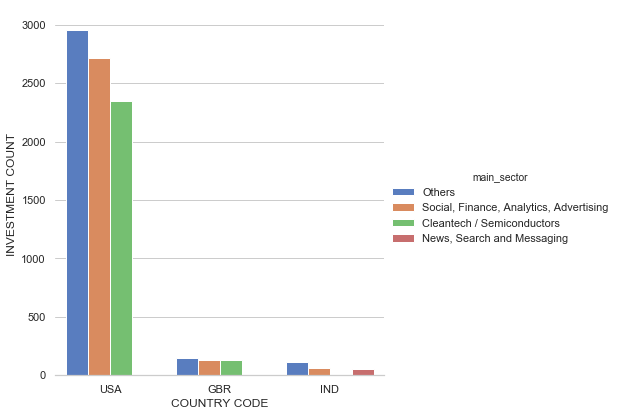

In [1134]:
sb.set(style="whitegrid")
plt.rcParams.update({'font.size': 14})
g = sb.catplot(x="country_code", y="investment_count_sectorwise", hue="main_sector", data=plot3_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("INVESTMENT COUNT")
g.set_xlabels("COUNTRY CODE")
g.savefig('sectorwise_investment.png',dpi=fig1.dpi,bbox_inches='tight')

END OF PLOT

In [1135]:
s = '0abc'
s.split('0')

['', 'abc']